## Fine Tuning Bert Model

In [ ]:
%ls

sample_data/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Bert/EmotionCodeAnalyzer/Notebook/Bert

/content/drive/MyDrive/Colab Notebooks/Bert/EmotionCodeAnalyzer/Notebook/Bert


In [ ]:
%ls

 BertFineTuningModel.ipynb   data_loader.py   __pycache__/
 best_model_state.bin        model.py        ' sentiment_model.pt'


In [ ]:
# !pip install transformers

In [ ]:
from transformers import BertTokenizer, BertModel,get_linear_schedule_with_warmup

In [ ]:
import pandas as pd
import glob
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap
from transformers import DataCollatorWithPadding
from transformers import logging
logging.set_verbosity_error()


In [ ]:
from data_loader import TextDataset
from model import SentimentClassifierModel, train_bert_model, eval_bert_model, get_bert_predictions

In [ ]:
pre_trained_model_ckpt = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)
collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
RANDOM_SEED = 42
MAX_LEN = 512
BATCH_SIZE = 64

In [ ]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
file_path = '../../Data/Prepared/CleanDatasets/'

In [ ]:
files = glob.glob(f'{file_path}*.csv')

In [ ]:
files

['../../Data/Prepared/CleanDatasets/Tweet_valid_clean.csv',
 '../../Data/Prepared/CleanDatasets/Tweet_train_clean.csv',
 '../../Data/Prepared/CleanDatasets/fin_phrase_bank_clean.csv',
 '../../Data/Prepared/CleanDatasets/financial_news_info.csv']

In [ ]:
df_train = pd.read_csv('../../Data/Prepared/CleanDatasets/Tweet_train_clean.csv')

In [ ]:
df_valid = pd.read_csv('../../Data/Prepared/CleanDatasets/Tweet_valid_clean.csv')

In [ ]:
df_val, df_test = train_test_split(df_valid, test_size = 0.2, random_state = RANDOM_SEED)

In [ ]:
df_train.head()

,text,label,clean_text,topic
0,Here are Thursday's biggest analyst calls: App...,0,thursday biggest analyst call apple amazon tes...,Analyst Update
1,Buy Las Vegas Sands as travel to Singapore bui...,0,buy la vega sand travel singapore build well f...,Analyst Update
2,"Piper Sandler downgrades DocuSign to sell, cit...",0,piper sandler downgrade docusign sell citing e...,Analyst Update
3,"Analysts react to Tesla's latest earnings, bre...",0,analyst react tesla latest earnings break next...,Analyst Update
4,Netflix and its peers are set for a ‘return to...,0,netflix peer set return growth analyst say giv...,Analyst Update


In [ ]:
print(f"validation: {df_val.shape}")
print(f"Test: {df_test.shape}")
print(f"Train: {df_train.shape}")


validation: (3293, 4)
Test: (824, 4)
Train: (16990, 4)


In [ ]:
class_names = sorted(df_train.label.unique())
class_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
df_train.label.value_counts()

2     3545
18    2118
14    1822
9     1557
5      987
16     985
1      837
19     823
7      624
6      524
15     501
17     495
12     487
13     471
4      359
3      321
0      255
8      166
10      69
11      44
Name: label, dtype: int64

In [ ]:
sorted(df_train.topic.unique())

['Analyst Update',
 'Company | Product News',
 'Currencies',
 'Dividend',
 'Earnings',
 'Energy | Oil',
 'Fed | Central Banks',
 'Financials',
 'General News | Opinion',
 'Gold | Metals | Materials',
 'IPO',
 'Legal | Regulation',
 'M&A | Investments',
 'Macro',
 'Markets',
 'Personnel Change',
 'Politics',
 'Stock Commentary',
 'Stock Movement',
 'Treasuries | Corporate Debt']

In [ ]:
def create_data_loader(
    df, tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE, include_raw_text=False
):
    ds = TextDataset(
        text=df.text.to_list(),
        targets=df.label.to_list(),
        tokenizer=tokenizer,
        max_len=max_len,
        include_raw_text=include_raw_text,
    )
    return DataLoader(ds, batch_size=batch_size, collate_fn=collator, shuffle=True)


In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer)

In [ ]:
val_data_loader = create_data_loader(df_val, tokenizer)

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer)

In [ ]:
model = SentimentClassifierModel(len(class_names))
model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
data = next(iter(train_data_loader))

print(data)
print(data.keys()) # dict_keys(['input_ids', 'attention_mask', 'targets'])

print(data['input_ids'].shape) # torch.Size([16, 512])

print(data['attention_mask'].shape) # torch.Size([16, 512])

print(data['targets'].shape) # torch.Size([16])

{'input_ids': tensor([[  101,  3041,  1024,  ...,     0,     0,     0],
        [  101,  2343,  8418,  ...,     0,     0,     0],
        [  101,  1002,  2002,  ...,     0,     0,     0],
        ...,
        [  101,  1002,  2038,  ...,     0,     0,     0],
        [  101,  1002, 13866,  ...,     0,     0,     0],
        [  101, 28667,  9331,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'targets': tensor([16,  9, 18, 15,  7, 18, 14,  2,  2,  2, 19, 14,  2,  1,  1,  6,  6, 18,
         5, 19, 18, 14,  7, 16, 14, 17, 18,  6, 18, 14,  1,  2,  6,  6,  5, 15,
         9,  6, 12,  8, 14,  2, 18, 19, 12, 18, 14, 18,  1,  2, 18, 14,  2,  5,
         2, 12, 10,  2, 14,  2, 17, 18, 18, 18])}
dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([64, 86])
torch.Size

In [ ]:
# Just An evaluation run of the model
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
F.softmax(model(input_ids,attention_mask), dim = 1)

tensor([[0.0196, 0.0634, 0.0874,  ..., 0.0301, 0.0730, 0.0385],
        [0.0219, 0.0402, 0.0619,  ..., 0.0442, 0.0555, 0.0490],
        [0.0197, 0.0496, 0.0657,  ..., 0.0211, 0.0792, 0.0386],
        ...,
        [0.0210, 0.0556, 0.0797,  ..., 0.0334, 0.0639, 0.0457],
        [0.0155, 0.0549, 0.0693,  ..., 0.0397, 0.0686, 0.0274],
        [0.0211, 0.0432, 0.0778,  ..., 0.0301, 0.0562, 0.0325]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
EPOCHS = 20

optimizer = optim.AdamW(model.parameters(), lr= 2e-5, eps = 1e-8)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps=total_steps)

# For multi-class classification you would usually just use nn.CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_bert_model(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_bert_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc>best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/ 20
---------------
  Batch    40  of    266.    Elapsed: 0:00:32.
  Batch    80  of    266.    Elapsed: 0:01:04.
  Batch   120  of    266.    Elapsed: 0:01:36.
  Batch   160  of    266.    Elapsed: 0:02:10.
  Batch   200  of    266.    Elapsed: 0:02:44.
  Batch   240  of    266.    Elapsed: 0:03:20.
Train loss 1.4948890303310596 accuracy 0.6179517507553101
Val loss 0.6717490765910882 accuracy 0.8399635553359985
Epoch 2/ 20
---------------
  Batch    40  of    266.    Elapsed: 0:00:37.
  Batch    80  of    266.    Elapsed: 0:01:12.
  Batch   120  of    266.    Elapsed: 0:01:48.
  Batch   160  of    266.    Elapsed: 0:02:24.
  Batch   200  of    266.    Elapsed: 0:03:01.
  Batch   240  of    266.    Elapsed: 0:03:37.
Train loss 0.49954698806194436 accuracy 0.8788699507713318
Val loss 0.4529375224732436 accuracy 0.8751897811889648
Epoch 3/ 20
---------------
  Batch    40  of    266.    Elapsed: 0:00:37.
  Batch    80  of    266.    Elapsed: 0:01:13.
  Batch   120  of    266.    

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

y_pred, y_pred_probs, y_test = get_bert_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        22
           1       0.97      0.95      0.96        41
           2       0.90      0.92      0.91       184
           3       1.00      0.79      0.88        14
           4       0.95      1.00      0.98        21
           5       0.96      0.98      0.97        55
           6       0.93      0.88      0.90        32
           7       0.90      0.87      0.89        31
           8       1.00      1.00      1.00         4
           9       0.93      0.86      0.89        63
          10       0.67      1.00      0.80         2
          11       0.50      1.00      0.67         1
          12       0.85      0.85      0.85        27
          13       0.88      0.73      0.80        30
          14       0.90      0.97      0.93        79
          15       0.80      0.89      0.84        18
          16       0.98      1.00      0.99        49
          17       0.91    

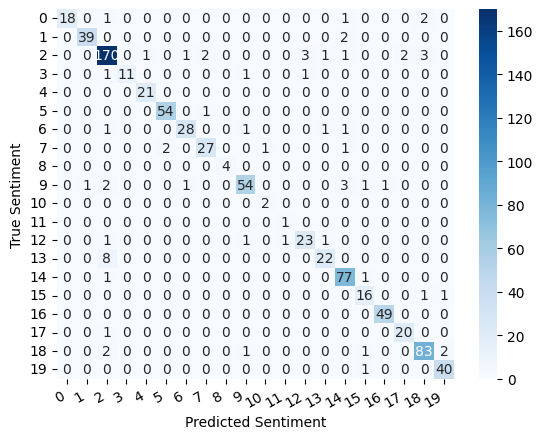

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

In [ ]:
torch.save(model.state_dict(), ' sentiment_model.pt')